In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv("datasets/jena_climate_2009_2016.csv")
df = df[5::6]

In [4]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Single Variable

In [ ]:
temp = df['T (degC)']
temp.plot()
results = seasonal_decompose(df['T (degC)'], period=30)
results.plot();

In [27]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [28]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [29]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [31]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=3, callbacks=[])

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 99.7851 - root_mean_squared_error: 9.8719 - val_loss: 3.0697 - val_root_mean_squared_error: 1.7521
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 8.8809 - root_mean_squared_error: 2.9576 - val_loss: 0.7238 - val_root_mean_squared_error: 0.8508
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9062 - root_mean_squared_error: 1.3780 - val_loss: 0.5539 - val_root_mean_squared_error: 0.7443


# Multi variate

In [5]:
temp = df['T (degC)']
temp = temp[5::6]
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 06:00:00,-9.67,1.000000e+00,4.339955e-12,0.013633,0.999907
2009-01-01 12:00:00,-6.87,6.903299e-12,-1.000000e+00,0.017933,0.999839
2009-01-01 18:00:00,-5.25,-1.000000e+00,-9.466643e-12,0.022233,0.999753
2009-01-02 00:00:00,-4.54,-1.202999e-11,1.000000e+00,0.026532,0.999648
2009-01-02 06:00:00,-4.43,1.000000e+00,4.141627e-14,0.030831,0.999525


In [6]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((11675, 6, 5), (11675,))

In [8]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((11675, 6, 5), (11675,), (0, 6, 5), (0,), (0, 6, 5), (0,))

In [9]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([], shape=(0, 6, 5), dtype=float64)

In [10]:
temp_training_mean

9.45535203426124

In [41]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 82.1846 - root_mean_squared_error: 8.8210 - val_loss: 4.0373 - val_root_mean_squared_error: 2.0093
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.8807 - root_mean_squared_error: 2.4207 - val_loss: 2.5377 - val_root_mean_squared_error: 1.5930
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.9704 - root_mean_squared_error: 1.7220 - val_loss: 1.4526 - val_root_mean_squared_error: 1.2052
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5719 - root_mean_squared_error: 1.2526 - val_loss: 0.9067 - val_root_mean_squared_error: 0.9522
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0561 - root_mean_squared_error: 1.0274 - val_loss: 0.6781 - val_root_mean_squared_error: 0.8235
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8013 - root_mean_squared_error: 0.8951 - val_loss: 0.5482 - val_root_mean_squared_error: 0.7404
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(      Predictions  Actuals
 0       13.059808    13.46
 1       12.602042    12.93
 2       12.222403    12.43
 3       11.946987    12.17
 4       12.073788    11.55
 ...           ...      ...
 5080    -1.195732    -0.98
 5081    -1.560822    -1.40
 5082    -1.783019    -2.75
 5083    -3.153299    -2.89
 5084    -3.249272    -3.93
 
 [5085 rows x 2 columns],
 0.508988600893736)

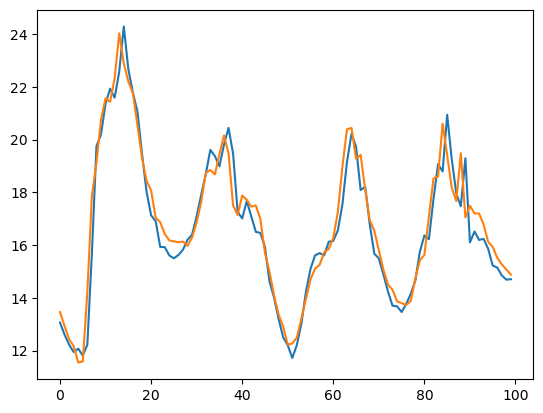

In [44]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

plot_predictions1(model4, X2_test, y2_test)